In [1]:
import os
from skimage import io
import numpy as np
import matplotlib.pyplot as plt
import cvxpy as cp

%matplotlib inline

import kagglehub
# Download latest version
path = kagglehub.dataset_download("jessicali9530/lfw-dataset")
print("Path to dataset files:", path)

/home/ccurtis/.conda/envs/math_596_fall_2024/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Path to dataset files: /home/ccurtis/.cache/kagglehub/datasets/jessicali9530/lfw-dataset/versions/4


In [2]:
# We need a tool that converts images into grayscale (i.e. all pixel values in [0, 1])
def gray_scale_convert(image):
    rescaled_image = np.zeros((image.shape[0], image.shape[1]))
    rescaled_image[:, :] = image
    rescaled_image -= np.min(rescaled_image)
    rescaled_image /= np.max(rescaled_image)
    return rescaled_image

In [3]:
# We need to be able to pass in a directory and build an image list
def file_builder(directory):
    image_list = []
    # iterate over files in
    # that directory
    cnt = 0
    for root, dirs, files in os.walk(directory):
        for filename in files:
            if ".csv" not in filename:
                input_matrix = io.imread(os.path.join(root, filename))
                height, width, ntot = input_matrix.shape
                for jj in range(ntot):                
                    squeeze_matrix = np.squeeze(input_matrix[:, :, jj])
                    input_image = gray_scale_convert(squeeze_matrix)
                    image_list.append( input_image )
                    cnt += 1
            if cnt >= 1000:
                return image_list            
    return image_list

In [4]:
work = os.getcwd()
print(f"Working directory is: {work}")
image_path = path + "/lfw-deepfunnled"
image_list = file_builder(path)

Working directory is: /home/ccurtis/Desktop/MATH_596_Git_Clone/Assignments


## Image detection via $l_1$ minimization

So the idea here is we take a big collection of images, split it into two sets, i.e. "train" and "test", with the understanding that the sets should have some overlap.  Each set of images is downsampled and flattened (like in Homework 2 and 3) so that we can then build an overcomplete dictionary from the train set and try to identify images in the test set relative to the overcomplete dictionary.  To make the selection process clear, we use $l_{1}$ minimization to generate sparse solutions to the image detection problem, i.e. we solve 

$$
\boldsymbol{\alpha}_{\ast} = \text{arg min}_{\boldsymbol{\alpha}}\left|\left|\boldsymbol{\alpha}\right|\right|_{1}, ~ \text{s.t.~} \frac{1}{2m}\left|\left|A\boldsymbol{\alpha}-{\bf b}\right|\right|_{2}^{2} \lt \epsilon
$$


See the following example for guidance. 

In [5]:
tot_images = len(image_list)
inds = np.arange(tot_images, dtype=int)

rng = np.random.default_rng()
rng.shuffle(inds) # shuffle image_list so we have a mix of repetitive images/views in both train and test

train_list = np.array(image_list)[ inds[:int(.8*tot_images)] ] # 80% of the images go into the overcomplete dictionary
test_list = np.array(image_list)[ inds[int(.8*tot_images):] ] # 20% of the images go into the testing set.  

# Each image is 250x250 pixels.  We downsample by a factor of 10 to get an overdetermined problem/overcomplete dictionary.  
train_mat = np.zeros((25*25,train_list.shape[0]))
test_mat = np.zeros((25*25,test_list.shape[0]))

for jj in range(train_list.shape[0]):
    train_col = train_list[jj][::10, ::10].flatten()
    train_mat[:, jj] = train_col/np.linalg.norm(train_col) # we normalize the columns of our dictionary
    
for jj in range(test_list.shape[0]):
    test_col = test_list[jj][::10, ::10].flatten()
    test_mat[:, jj] = test_col/np.linalg.norm(test_col) # we normalize the columns of our test set matrix


In [6]:
# Setup and solve convex optimization problem/l_1 minimization problem

alpha = cp.Variable(train_mat.shape[1])
ep = cp.Parameter(nonneg=True)

objective = cp.Minimize(cp.norm(alpha, 1)) # minimize l_1 norm
constraint = [cp.sum_squares(train_mat@alpha-test_mat[:, 0])/(2.*train_mat.shape[0]) <= ep] # constrain solver to find near solution to A * alpha = b
prob = cp.Problem(objective, constraint)

ep.value = 1e-5 # set radius of constraint 
prob.solve()

1.8438890454492514

Let's look at our solution $\boldsymbol{\alpha}_{\ast}$.  Note all that sweet sparsity.  

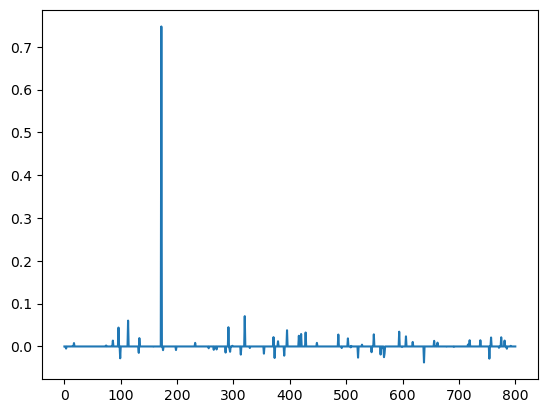

In [7]:
plt.plot(alpha.value)

Here is the image we used as our test.  

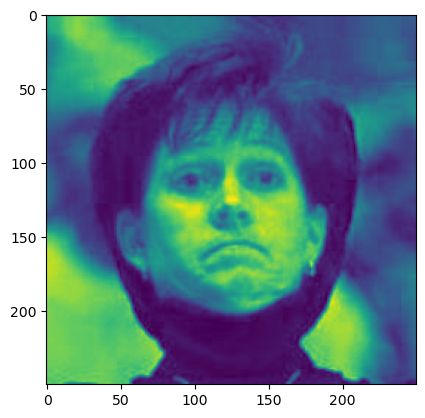

In [8]:
plt.imshow(test_list[0])

Here is the image we ended up selecting using our $l_{1}$ minimization scheme.  

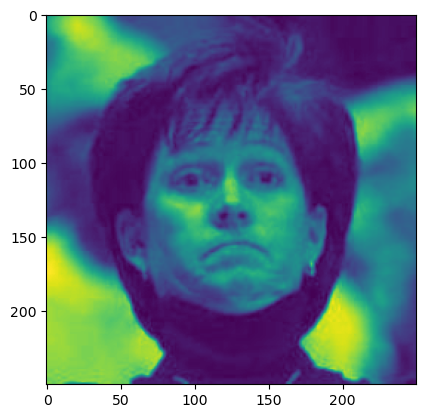

In [ ]:
image_detected = np.argmax(np.abs(alpha.value))
plt.imshow(train_list[image_detected])

## Problems

**Problem 1**: We defined the *coherence* of a $n\times m$ matrix $A$, say $\mu(A)$, to be 

$$
\mu(A) = \text{max}_{1\leq i < j \leq m} \left|\left<\hat{{\bf a}}^{(c)}_{i}, \hat{{\bf a}}^{(c)}_{j}\right> \right|, 
$$

where $\hat{{\bf a}}^{(c)}_{i}$ denotes the $i^{th}$ normalized column of $A$.  As we showed in class, we expect that $\left|\left|\boldsymbol{\alpha}\right|\right|_{0}$ satisfies the bound:

$$
\left|\left|\boldsymbol{\alpha}\right|\right|_{0} \leq \frac{1}{2}\left(1 + \frac{1}{\mu(A)} \right).
$$

* Find $\mu(A)$, or find the coherence of your training matrix. *Hint*: $A^{T}A$ is your friend here.  
* Compute $\left|\left|\boldsymbol{\alpha}\right|\right|_{0}$ using the example above.  
* Does your computed coherence give you a useful bound relative to the value of $\left|\left|\boldsymbol{\alpha}\right|\right|_{0}$ that you compute.  

Note, $\left|\left|\boldsymbol{\alpha}\right|\right|_{0} = \text{number of non-zero entries of vector}$.

In [38]:
def coherence_comp(A):
    tmat = np.triu(np.abs(A.T @ A))
    np.fill_diagonal(tmat, 0)
    ftmat = tmat.flatten()
    fast_cohere = np.max(ftmat)

    slow_cohere = 0.
    for jj in range(A.shape[1]):
        for kk in range(jj+1, A.shape[1]):
            tval = np.abs( np.sum( A[:, jj] * A[:, kk] ) )
            slow_cohere = np.max(np.array([tval, slow_cohere])) 

    return [fast_cohere, slow_cohere]

print(f"The coherence of our training matrix is: {coherence_comp(train_mat)}")
print(f"The zero norm of our solution is: {len(np.nonzero(alpha.value)[0])}")

The coherence of our training matrix is: [1.0000000000000002, 0.9999999999999999]
The zero norm of our solution is: 801


So, we see that $\mu(A)$ is essentially 1, with any deviation being a result of round-off error.  And this tracks, given that we know we are putting in images which are all but copies of one another.  Thus,  if the zero-norm result held, we should expect $\left|\left|\boldsymbol{\alpha}\right|\right|_{0}=1$.  However, we do not come close to this result, though we do note that there is one markedly larger value of $\boldsymbol{\alpha}$ than the others, so it is almost true in some thresholded sense.  This implies we have quite a ways to go to getting the sparsest possible solution, though in practice we see this makes little difference.  

**Problem 2**: Modify the code above to add Gaussian noise to your test images before you perform the downsampling and flattening process.  The noise then should be a $250\times 250$ matrix, say $N$, such that $N_{ij}\sim \mathcal{N}(0,\sigma)$.  Note, as you change $\sigma$, you will have to adjust `ep_val` in your convex optimization solver accordingly.  

* Describe the results of your image detection for $\sigma=.1$
* Describe the results of your image detection for $\sigma=1.$
* What would you say is the highest level of noise you can have before your method just fails?  

In [99]:
def noisy_tests(sval, train_mat, test_list):
    # Don't keep drawing a new image because this just creates unneccesary headaches.  
    noisy_test_list = test_list + sval*np.abs(np.random.randn(test_list.shape[0], 250, 250))

    for jj in range(test_list.shape[0]):
        test_col = noisy_test_list[jj][::10, ::10].flatten()
        test_mat[:, jj] = test_col/np.linalg.norm(test_col) # we normalize the columns of our test set matrix

    alpha = cp.Variable(train_mat.shape[1])
    ep = cp.Parameter(nonneg=True)

    objective = cp.Minimize(cp.norm(alpha, 1)) # minimize l_1 norm
    constraint = [cp.sum_squares(train_mat@alpha-test_mat[:, 0])/(2.*train_mat.shape[0]) <= ep] # constrain solver to find near solution to A * alpha = b
    prob = cp.Problem(objective, constraint)

    ep.value = 1e-5 # set radius of constraint 
    prob.solve()

    image_detected = np.argmax(np.abs(alpha.value))
    fig = plt.figure(figsize=(12,4))
    ax=fig.add_subplot(1,3,1)
    ax.imshow(train_list[image_detected])
    ax.set_title(f"Detected Image for s={sval}")
    ax=fig.add_subplot(1,3,2)
    ax.set_title(f"Noisy Test Image for s={sval}")
    ax.imshow(noisy_test_list[0])
    ax=fig.add_subplot(1,3,3)
    ax.set_title(fr"$\alpha$")
    ax.plot(np.abs(alpha.value))

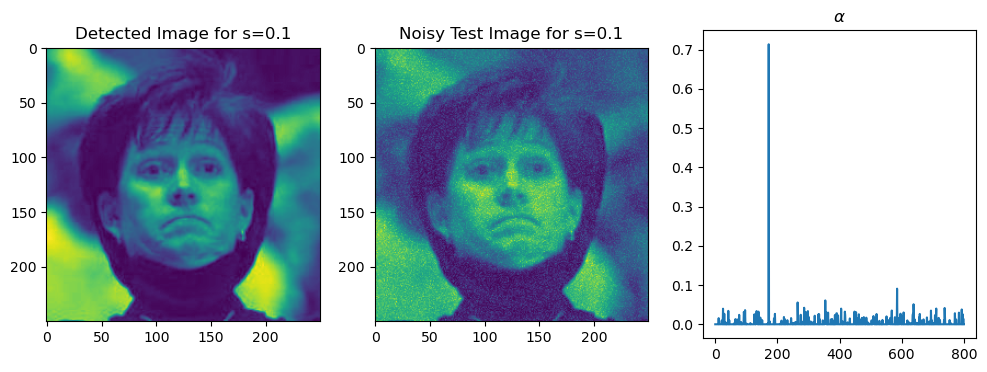

In [100]:
noisy_tests(sval=.1, train_mat=train_mat, test_list=test_list)

So, for $\sigma=.1$, while we see that the $\boldsymbol{\alpha}$ vector has a larger distribution of values, and thus some of our beloved sparsity is lost, we still get a clear choice for the most likely image.  

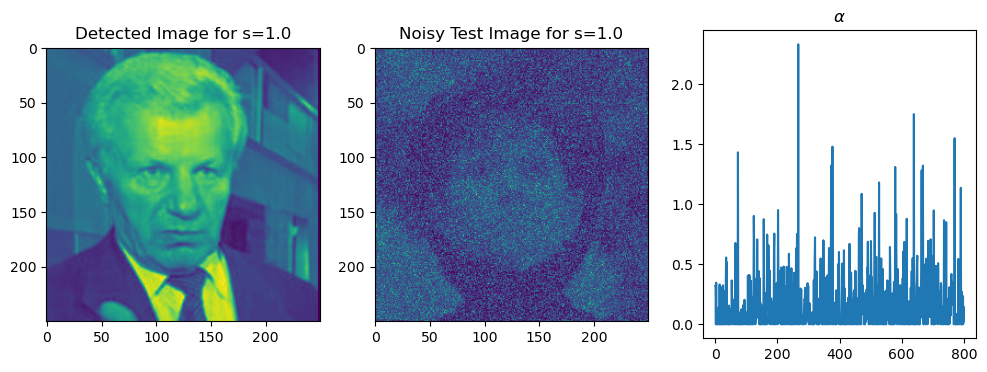

In [101]:
noisy_tests(sval=1., train_mat=train_mat, test_list=test_list)

For $\sigma=1.$, we see that the image is now almost entirely obscured, the detected image is all but a random selection.  So we can expect anymore noise will produce as poor of an outcome.  However, we do note that there is a nearby peak in $\boldsymbol{\alpha}$ corresponding to our original image, so it's not completely hopeless.  

To make this slightly more interesting, let's see if we can find a threshhold value for $\sigma$ to see what the tipping point in this approach is.  Let's try $\sigma=.25$ and $\sigma=.4$.

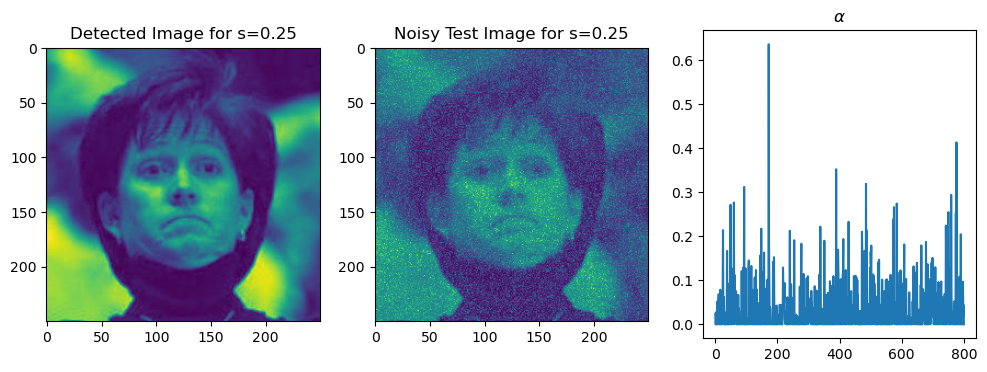

In [107]:
noisy_tests(sval=.25, train_mat=train_mat, test_list=test_list)

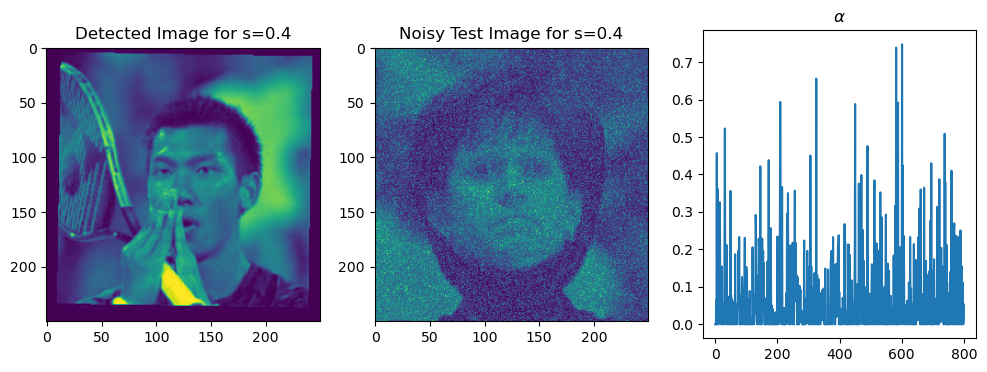

In [108]:
noisy_tests(sval=.4, train_mat=train_mat, test_list=test_list)

As we can see, while we still get the `correct' answer, looking at $\boldsymbol{\alpha}$, we are on the verge of picking incorrect options, so we have found the boundary of where noise causes our method to breakdown. This is frustrating since to the eye, we can still recognize the image and clearly see that the chosen image is not similar.  